In [1]:
import os, sys
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,3)

np.random.seed(42)
tf.random.set_seed(42)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices([physical_devices[0]], 'GPU')

# Data loading

In [3]:
# Loading data from already prepared datasets
X_train, y_train, mean_features_train = (
    np.load('./data/X_train_shuffled_with_mean_model.npz'), 
    np.load('./data/y_train_shuffled_with_mean_model.npz'),
    np.load('./data/mean_features_train_shuffled_with_mean_model.npz'))
X_train, y_train, mean_features_train = X_train['arr_0'], y_train['arr_0'], mean_features_train['arr_0']

X_valid, y_valid, mean_features_valid = (
    np.load('./data/X_valid_shuffled_with_mean_model.npz'), 
    np.load('./data/y_valid_shuffled_with_mean_model.npz'), 
    np.load('./data/mean_features_valid_shuffled_with_mean_model.npz'))
X_valid, y_valid, mean_features_valid = X_valid['arr_0'], y_valid['arr_0'], mean_features_valid['arr_0']

X_test, y_test, mean_features_test = (
    np.load('./data/X_test_shuffled_with_mean_model.npz'), 
    np.load('./data/y_test_shuffled_with_mean_model.npz'),
    np.load('./data/mean_features_test_shuffled_with_mean_model.npz'))
X_test, y_test, mean_features_test = X_test['arr_0'], y_test['arr_0'], mean_features_test['arr_0']

In [4]:
y_test_org = np.copy(y_test)

# y categorization

In [5]:
one_ids = np.where(y_train >= 0.9)
zero_ids = np.where(y_train < 0.9)

y_train[one_ids[0], one_ids[1]] = 1
y_train[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_train = y_train.astype(np.int)

Positive %: 0.04737364845037358
Negative %: 0.9526263515496264


In [6]:
one_ids = np.where(y_valid >= 0.9)
zero_ids = np.where(y_valid < 0.9)

y_valid[one_ids[0], one_ids[1]] = 1
y_valid[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_valid = y_valid.astype(np.int)

Positive %: 0.062239534739068236
Negative %: 0.9377604652609317


In [7]:
one_ids = np.where(y_test >= 0.9)
zero_ids = np.where(y_test < 0.9)

y_test[one_ids[0], one_ids[1]] = 1
y_test[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_test = y_test.astype(np.int)

Positive %: 0.05826417435817886
Negative %: 0.9417358256418211


In [8]:
y_all = np.concatenate((y_train, y_valid, y_test))
temp = np.copy(y_all)
temp.shape

one_ids = np.where(temp >= 0.9)
zero_ids = np.where(temp < 0.9)

temp[one_ids[0], one_ids[1]] = 1
temp[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

unique, counts = np.unique(y_all, return_counts=True)
for val, qty in zip(unique, counts):
    print(f'Label {val}: {qty}')

Positive %: 0.05148319973085612
Negative %: 0.9485168002691439
Label 0: 603343
Label 1: 32748


# Mean model (EMA model)

In [9]:
class MeanModel(sklearn.base.BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def predict(self, batch: np.ndarray):
        # Check X len
        if batch.shape[1] != 4:
            raise Exception(f'Input lenght incorrect, should be equal 4.')
        results = []
        for X in batch:
            prev_avg_price = X[0]
            curr_avg_price = X[1]
            prev_ema = X[2]
            curr_ema = X[3]
            if prev_avg_price > prev_ema and curr_avg_price < curr_ema:
                results.append(1)
            else:
                results.append(0)
        return np.array(results)

# Predictions

In [10]:
mean_model = MeanModel()
y_pred = mean_model.predict(mean_features_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([63423,  1042]))

In [12]:
sell_points_ids = np.where(y_pred == 1.0)[0]
sell_points_ids

array([  257,   456,   462, ..., 64337, 64356, 64394])

# Metrics

total: 64465
[[9.26083922e-01 1.56519041e-02]
 [5.77522687e-02 5.11905685e-04]]


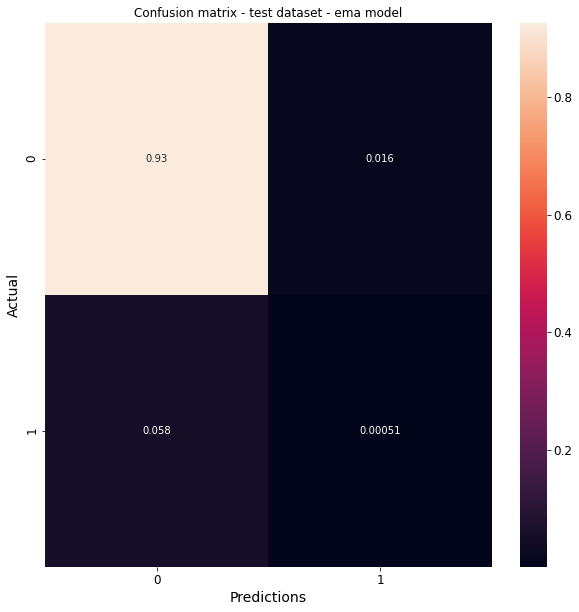

In [13]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predictions')
plt.title('Confusion matrix - test dataset - ema model')
plt.show()

In [14]:
report = sklearn.metrics.classification_report(y_test, y_pred)
print('Test dataset')
print(report)

Test dataset
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     60709
           1       0.03      0.01      0.01      3756

    accuracy                           0.93     64465
   macro avg       0.49      0.50      0.49     64465
weighted avg       0.89      0.93      0.91     64465



# Metric for whole dataset

In [21]:
mean_features_all = np.concatenate((mean_features_train, mean_features_valid, mean_features_test))
y = np.concatenate((y_train, y_valid, y_test))

In [22]:
y_pred_whole = mean_model.predict(mean_features_all)
y_pred_whole

array([0, 0, 0, ..., 0, 0, 0])

total: 636091
[[9.32809928e-01 1.57068721e-02]
 [5.10823137e-02 4.00886037e-04]]


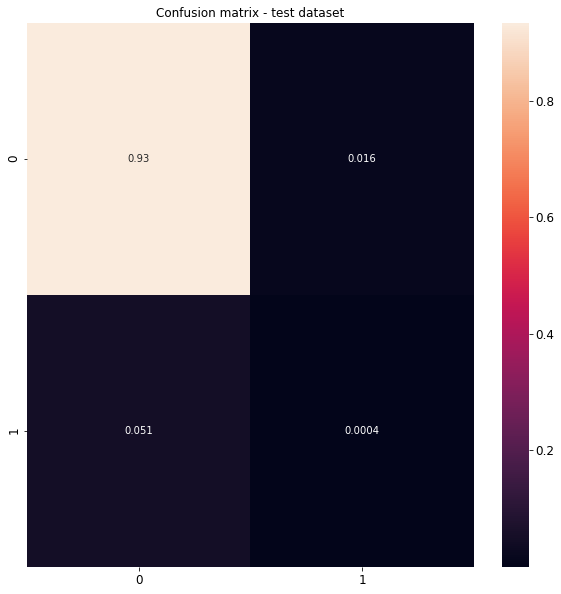

In [23]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y, y_pred_whole)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix - test dataset')
plt.show()

In [24]:
report = sklearn.metrics.classification_report(y, y_pred_whole)
print('Test dataset')
print(report)

Test dataset
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    603343
           1       0.02      0.01      0.01     32748

    accuracy                           0.93    636091
   macro avg       0.49      0.50      0.49    636091
weighted avg       0.90      0.93      0.92    636091



# Histogram

In [15]:
ids = np.where(y_pred == 1)[0]
ids

array([  257,   456,   462, ..., 64337, 64356, 64394])

In [16]:
y_test_org[ids]

array([[0.41914781],
       [0.69170153],
       [0.66529916],
       ...,
       [0.63201872],
       [0.6453877 ],
       [0.64171123]])

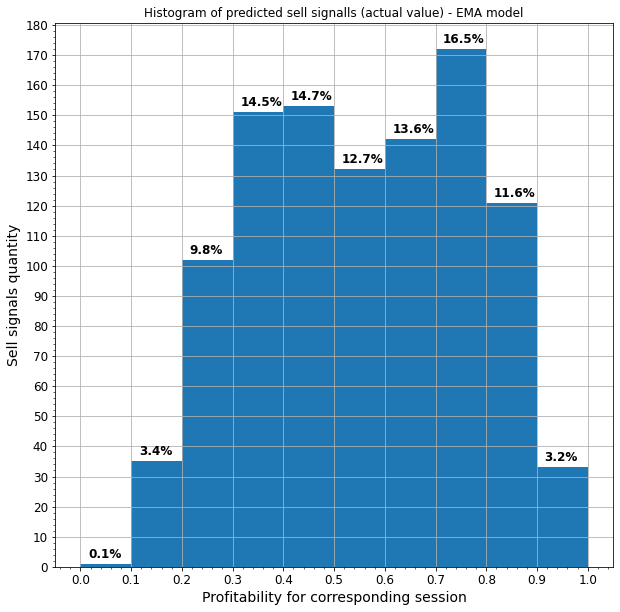

In [17]:
plt.figure(figsize=(10,10))
n, bins, _ = plt.hist(y_test_org[ids], bins=10, range=(0, 1), histtype='bar')
plt.title('Histogram of predicted sell signalls (actual value) - EMA model')
plt.xlabel('Profitability for corresponding session')
plt.ylabel('Sell signals quantity')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0, 190, 10))
plt.minorticks_on()
total_samples = len(y_test_org[ids])
for samples_qty, rectangle in zip(n, _):
    xy = (rectangle.xy[0] + 0.015, rectangle.get_height() + 2)
    perc = round((samples_qty/total_samples) * 100, 1)
    plt.annotate(f'{perc}%', xy, fontweight='bold', size='large')
plt.grid()
plt.show()

In [20]:
predicted_y_test_org = y_test_org[ids]
min, max, mean = np.min(predicted_y_test_org), np.max(predicted_y_test_org), np.mean(predicted_y_test_org)
median, scores_range, std = np.median(predicted_y_test_org), max-min, np.std(predicted_y_test_org)

statistics = {
    "Min": min,
    "Max": max,
    "Mean": mean,
    "Median": median,
    "Range": scores_range,
    "Standard deviation": std
}
statistics

{'Min': 0.09492122516880647,
 'Max': 0.9683180948330851,
 'Mean': 0.5587432650911768,
 'Median': 0.5531160276980347,
 'Range': 0.8733968696642787,
 'Standard deviation': 0.2113192073627826}